In [1]:
import sys
import os
import subprocess
    
import math
import re
# import collections
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
# from tqdm import tqdm
import traceback
import hashlib
import datetime

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import postgresql_v3_event_storage
from tool.misc.event_analysis_record_v3_6_update import EventAnalysisRecordV3_6_update
import dataset_query_functions_v3

#import ROOT

# import tool.npy_frames_visualization as npy_vis
import tool.acqconv
from data_analysis_utils import *
from event_recognition_efficiency_v3 import *
# import supervised_classification as supc    


Welcome to JupyROOT 6.13/02


In [3]:
events_data_table_name = 'spb_processing_v3_flatmap.event'
# events_data_table_name = '_old3_spb_processing_v3.event'

In [4]:
data_snippets_dir = 'ver3_flatmap_data_snippets'
os.makedirs(data_snippets_dir, exist_ok=True)

# Selecting data

In [5]:
event_processing_cls = event_processing_v3.EventProcessingV3
event_processing_cls.event_analysis_record_class = EventAnalysisRecordV3_6_update
event_v3_storage_provider = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config.ini'), 
    table_names_version='ver3',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider)

In [6]:
columns_for_analysis_dict = query_functions.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=(
        '^.+$',
    ),
    
    default_excluded_columns_re_list=[],
#     for debugging selection
    included_columns_re_list=[('^$','^source_file_acquisition_full$'), ('^$','^source_file_acquisition$'), ('^$','^global_gtu$'), ('^$','^packet_id$'), 
                              ('^$','gtu_in_packet'), ('^$','event_id'), ('^$','num_gtu'), 
                              '^bg_.*', 
                              ('gtu_datetime','min'), 
                              ('gps_lat','mean'), ('gps_lon','mean'), ('gps_alt','mean')
                             ]
)

In [7]:
removed_cols = {'spb_processing_v3.event_bg_x_y':['median','median_gz','size']}
for table,cols_list in columns_for_analysis_dict.items():
    if table not in removed_cols:
        continue
    for removed_col in removed_cols[table]:
        try:
            del cols_list[ cols_list.index(removed_col) ]
        except ValueError:
            pass
    
columns_for_analysis_dict

{'spb_processing_v3.event': ['event_id',
  'source_file_acquisition_full',
  'source_file_acquisition',
  'global_gtu',
  'packet_id',
  'gtu_in_packet',
  'num_gtu'],
 'spb_processing_v3.event_bg': ['event_id',
  'count_nonzero',
  'sum',
  'norm_sum',
  'min',
  'max',
  'mean',
  'std',
  'mean_gz',
  'std_gz',
  'size',
  'median',
  'median_gz'],
 'spb_processing_v3.event_bg_gtu_x': ['event_id',
  'count_nonzero',
  'sum',
  'norm_sum',
  'min',
  'max',
  'mean',
  'std',
  'mean_gz',
  'std_gz',
  'size',
  'median',
  'median_gz',
  'width',
  'height',
  'area'],
 'spb_processing_v3.event_bg_gtu_x_clusters': ['event_id',
  'count',
  'sizes_min',
  'sizes_max',
  'sizes_mean',
  'sizes_std',
  'sums_sum',
  'sums_min',
  'sums_max',
  'sums_mean',
  'sums_std',
  'clu_widths_max',
  'clu_heights_max',
  'clu_widths_min',
  'clu_widths_mean',
  'clu_heights_mean',
  'clu_widths_std',
  'clu_heights_std',
  'clu_areas_min',
  'clu_areas_max',
  'clu_areas_mean',
  'clu_areas_std

In [8]:
#import pprint
split_columns_for_analysis_dict = query_functions.split_to_smaller_dicts(columns_for_analysis_dict,300)
#print(select_clause_str)
for i,g in enumerate(split_columns_for_analysis_dict):
    tot_items = 0
    for k,vl in g.items():
        tot_items += len(vl)
    print(i,tot_items)
    
    for t, vl in g.items():
        sys.stdout.write(t)
        sys.stdout.write('\n\t- ')
        print('\n\t- '.join(vl))
        print()
    
    print('-'*60)

0 231
spb_processing_v3.event
	- event_id
	- source_file_acquisition_full
	- source_file_acquisition
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v3.event_gps_lat
	- mean

spb_processing_v3.event_gps_lon
	- mean

spb_processing_v3.event_gps_alt
	- mean

spb_processing_v3.event_gtu_datetime
	- min

spb_processing_v3.event_bg_x_y
	- event_id
	- count_nonzero
	- sum
	- norm_sum
	- min
	- max
	- mean
	- std
	- mean_gz
	- std_gz
	- width
	- height
	- area

spb_processing_v3.event_bg_x_y_clusters
	- event_id
	- count
	- sizes_min
	- sizes_max
	- sizes_mean
	- sizes_std
	- sums_sum
	- sums_min
	- sums_max
	- sums_mean
	- sums_std
	- clu_widths_max
	- clu_heights_max
	- clu_widths_min
	- clu_widths_mean
	- clu_heights_mean
	- clu_widths_std
	- clu_heights_std
	- clu_areas_min
	- clu_areas_max
	- clu_areas_mean
	- clu_areas_std
	- max_area_clu_width
	- max_area_clu_height
	- min_area_clu_width
	- min_area_clu_height
	- max_size_clu_width
	- max_size_clu_height
	- min_s

In [9]:
current_columns_for_analysis_dict = split_columns_for_analysis_dict[0]

select_clause_str, joined_tables_list = \
    query_functions.get_query_clauses__select(current_columns_for_analysis_dict)
join_clauses_str = \
    query_functions.get_query_clauses__join(joined_tables_list)
where_clauses_str = ' AND config_info_id=1'
    
events_selection_query = query_functions.get_events_selection_query_plain(
    source_data_type_num=1,
    select_additional=select_clause_str, join_additional=join_clauses_str,
    where_additional=where_clauses_str,
    order_by='{data_table_name}.event_id', limit=350000, offset=0,
    base_select='',
    data_table_name_overwrite=events_data_table_name)

print(events_selection_query)


    SELECT 
        
        spb_processing_v3_flatmap.event.event_id, spb_processing_v3_flatmap.event.source_file_acquisition_full, spb_processing_v3_flatmap.event.source_file_acquisition, spb_processing_v3_flatmap.event.global_gtu, spb_processing_v3_flatmap.event.packet_id, spb_processing_v3_flatmap.event.gtu_in_packet, spb_processing_v3_flatmap.event.num_gtu, spb_processing_v3.event_gps_lat.mean AS gps_lat_mean, spb_processing_v3.event_gps_lon.mean AS gps_lon_mean, spb_processing_v3.event_gps_alt.mean AS gps_alt_mean, spb_processing_v3.event_gtu_datetime.min AS gtu_datetime_min, spb_processing_v3.event_bg_x_y.event_id AS bg_x_y_event_id, spb_processing_v3.event_bg_x_y.count_nonzero AS bg_x_y_count_nonzero, spb_processing_v3.event_bg_x_y.sum AS bg_x_y_sum, spb_processing_v3.event_bg_x_y.norm_sum AS bg_x_y_norm_sum, spb_processing_v3.event_bg_x_y.min AS bg_x_y_min, spb_processing_v3.event_bg_x_y.max AS bg_x_y_max, spb_processing_v3.event_bg_x_y.mean AS bg_x_y_mean, spb_processing_v3.

In [10]:
flight_data_df = psql.read_sql(events_selection_query, event_v3_storage_provider.connection)

In [11]:
flight_data_df

,event_id,source_file_acquisition_full,source_file_acquisition,global_gtu,packet_id,gtu_in_packet,num_gtu,gps_lat_mean,gps_lon_mean,gps_alt_mean,...,bg_norm_sum,bg_min,bg_max,bg_mean,bg_std,bg_mean_gz,bg_std_gz,bg_size,bg_median,bg_median_gz
0,1,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,169,1,41,9,-36.7629,-171.669,30842.0,...,-1.000,0,0,0.000000,0.000000,-1.00000,-1.000000,36.0,0.0,-1.0
1,2,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,222,1,94,9,-36.7629,-171.669,30842.0,...,-1.000,0,0,0.000000,0.000000,-1.00000,-1.000000,36.0,0.0,-1.0
2,3,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,238,1,110,14,-36.7624,-171.666,30838.8,...,-1.000,0,0,0.000000,0.000000,-1.00000,-1.000000,36.0,0.0,-1.0
3,4,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,424,3,40,17,-36.7613,-171.662,30828.6,...,-1.000,0,0,0.000000,0.000000,-1.00000,-1.000000,36.0,0.0,-1.0
4,5,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,445,3,61,10,-36.7607,-171.660,30822.3,...,-1.000,0,0,0.000000,0.000000,-1.00000,-1.000000,36.0,0.0,-1.0
5,6,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,662,5,22,9,-36.7602,-171.657,30815.6,...,-1.000,0,0,0.000000,0.000000,-1.00000,-1.000000,36.0,0.0,-1.0
6,7,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,681,5,41,9,-36.7596,-171.655,30809.2,...,-1.000,0,0,0.000000,0.000000,-1.00000,-1.000000,36.0,0.0,-1.0
7,8,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,721,5,81,9,-36.7591,-171.653,30802.5,...,-1.000,0,0,0.000000,0.000000,-1.00000,-1.000000,36.0,0.0,-1.0
8,9,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,807,6,39,10,-36.7586,-171.651,30797.2,...,-1.000,0,0,0.000000,0.000000,-1.00000,-1.000000,36.0,0.0,-1.0
9,10,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,936,7,40,17,-36.7586,-171.651,30797.2,...,-1.000,0,0,0.000000,0.000000,-1.00000,-1.000000,36.0,0.0,-1.0


In [12]:
flight_data_df.gtu_datetime_min.min()

Timestamp('2017-04-25 08:31:48.041307')

In [13]:
i = 0
# for n,g in flight_data_df.groupby('source_file_acquisition_full'):
#     print(n, g['global_gtu'].min())
#     j=0
#     for t,r in g.iterrows():
#         print(t, r.event_id, r.global_gtu)
#         j+=1
#         if j > 5: break
#     i += 1
#     if i > 5:
#          break

flight_data_df.iloc[0]['global_gtu']

169

# Distributions

In [14]:
len(flight_data_df[flight_data_df.bg_size >= 36])/len(flight_data_df) # [flight_data_df.bg_size >= 36]

0.6224523440266703

In [15]:
## gtu_datetime

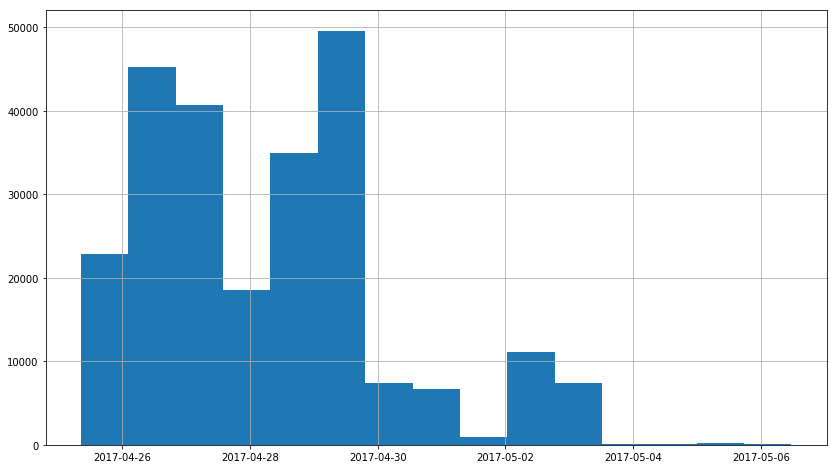

In [16]:
flight_data_df.gtu_datetime_min.hist(bins=15,figsize=(14,8))
plt.show()

In [18]:
flight_data_df.gtu_datetime_min.min()

Timestamp('2017-04-25 08:31:48.041307')

## bg_size

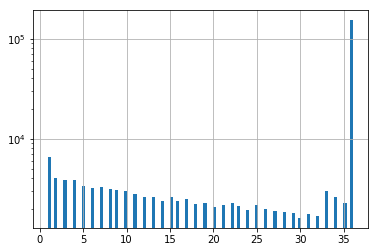

In [19]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_size.hist(bins=100)
h.set_yscale('log')
plt.show()

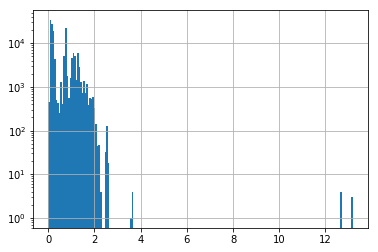

0.239788
0.5429243145223521
152916


In [20]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[(flight_data_df.bg_size >= 36)]
h = filtered_df.bg_mean.hist(bins=200)
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))
print(len(filtered_df))

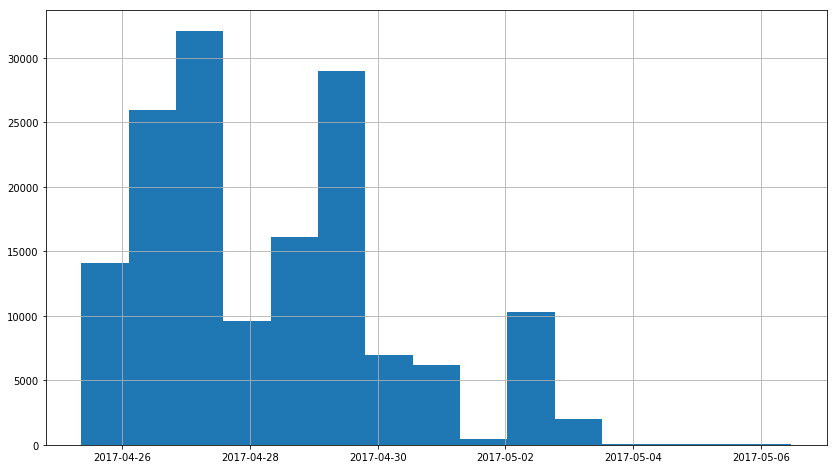

In [21]:
filtered_df.gtu_datetime_min.hist(bins=15,figsize=(14,8))
plt.show()

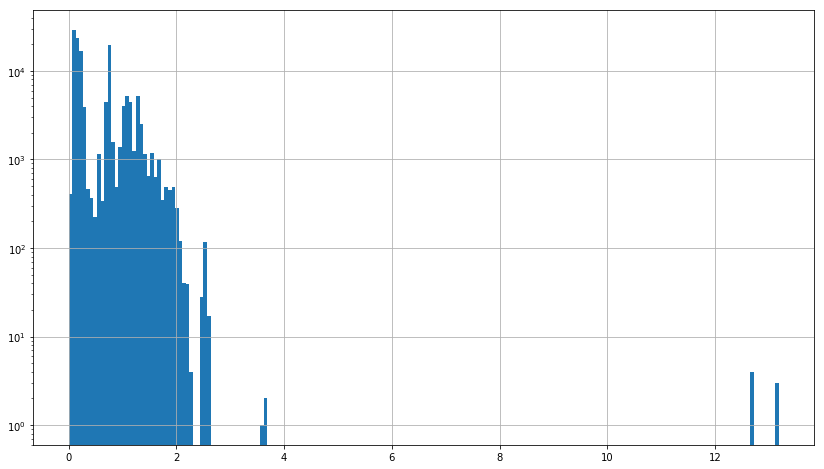

0.239981
0.5436112654999964
133371


In [22]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[(flight_data_df.bg_size >= 36) & (flight_data_df.gtu_in_packet >= 38)]
h = filtered_df.bg_mean.hist(bins=200,figsize=(14,8))
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))
print(len(filtered_df))

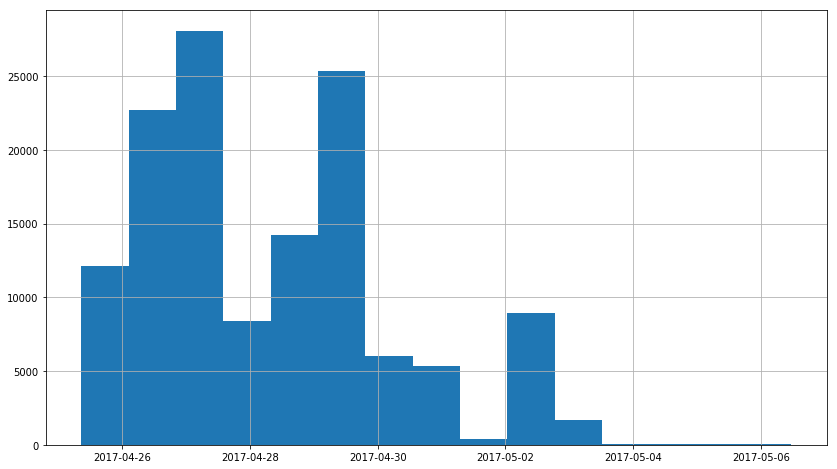

In [23]:
filtered_df.gtu_datetime_min.hist(bins=15,figsize=(14,8))
plt.show()

In [24]:
filtered_df.gtu_datetime_min.min()

Timestamp('2017-04-25 08:31:48.041307')

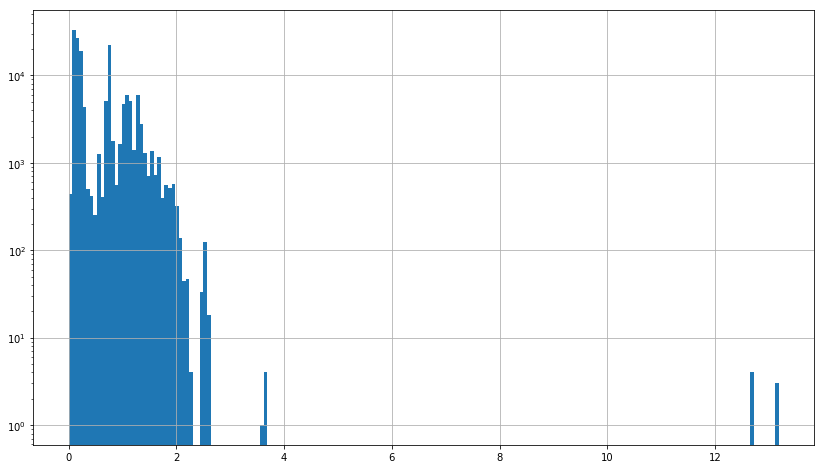

0.239788
0.5429243145223521
152916


In [25]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[(flight_data_df.bg_size >= 36) ]
h = filtered_df.bg_mean.hist(bins=200,figsize=(14,8))
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))
print(len(filtered_df))

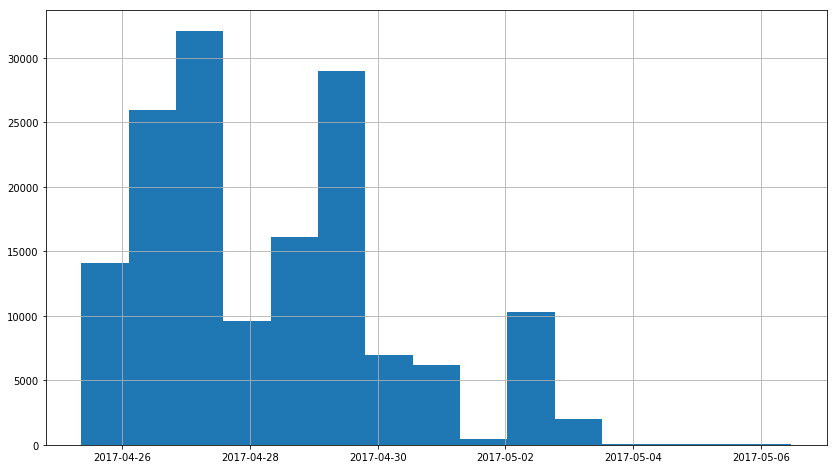

In [26]:
filtered_df.gtu_datetime_min.hist(bins=15,figsize=(14,8))
plt.show()

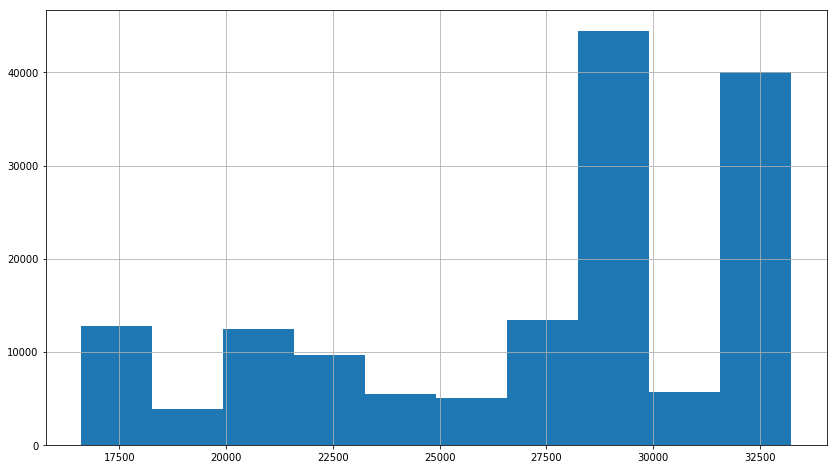

In [27]:
filtered_df.gps_alt_mean.hist(bins=10,figsize=(14,8))
plt.show()

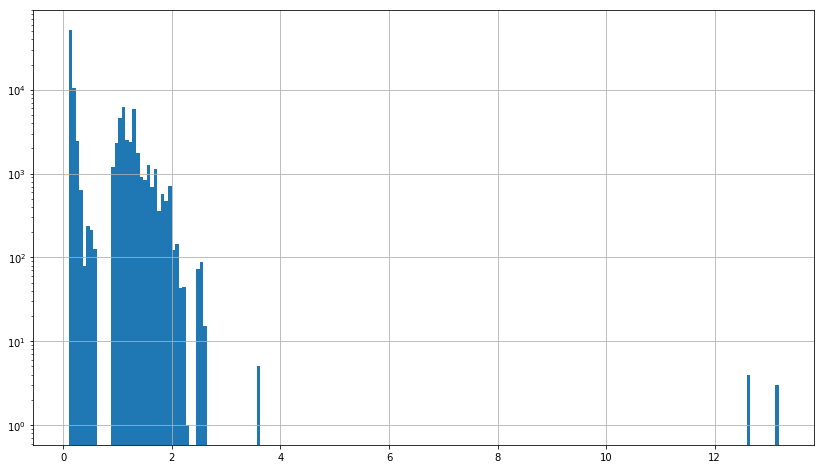

0.156793
0.532871274005864
100615


In [28]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[(flight_data_df.bg_size >= 36) & (flight_data_df.bg_x_y_count_nonzero > 8*8*4*7)]
h = filtered_df.bg_mean.hist(bins=200,figsize=(14,8))
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))
print(len(filtered_df))


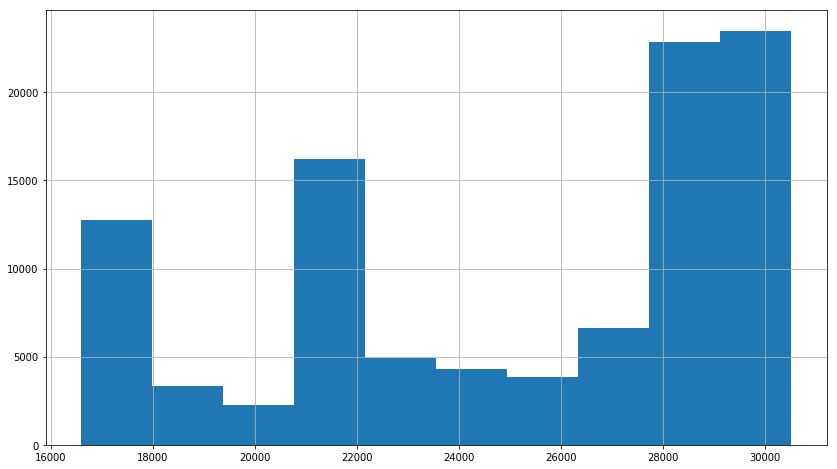

In [29]:
filtered_df.gps_alt_mean.hist(bins=10,figsize=(14,8))
plt.show()

In [30]:
filtered_df.gtu_datetime_min.min()

Timestamp('2017-04-27 08:25:12.000200')

## Altitude - background relation

0    0.00  0.10  46     23852.800  23992.100 


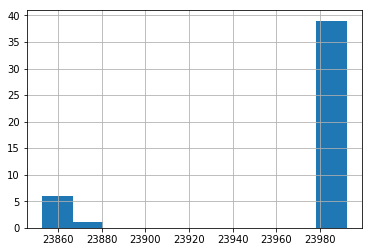

1    0.10  0.20  60362  16601.400  30516.400 


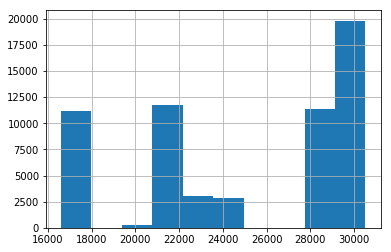

2    0.20  0.30  4895   16687.300  22692.900 


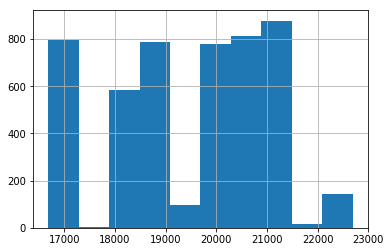

3    0.30  0.40  448    16796.300  19797.800 


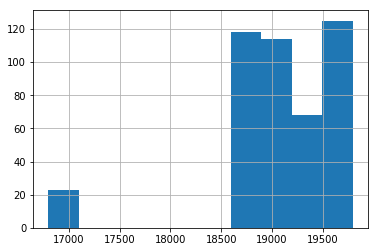

4    0.40  0.50  298    26079.100  30322.800 


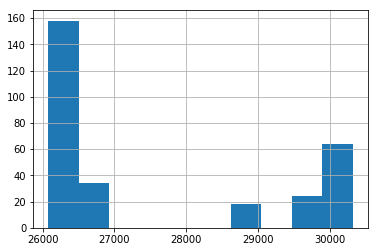

5    0.50  0.60  298    26697.700  30479.100 


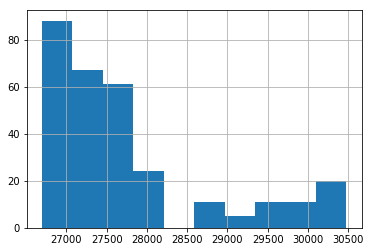

6    0.60  0.70  15     26867.700  26880.400 


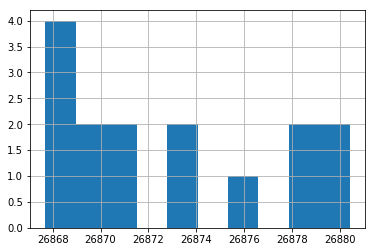

7    0.70  0.80  0      nan        nan       
8    0.80  0.90  0      nan        nan       
9    0.90  1.00  2626   21299.000  29824.000 


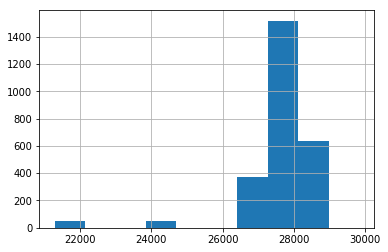

10   1.00  1.10  7997   21238.700  29824.000 


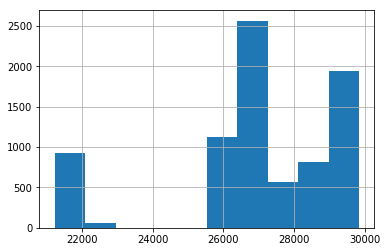

11   1.10  1.20  5863   19741.700  29652.300 


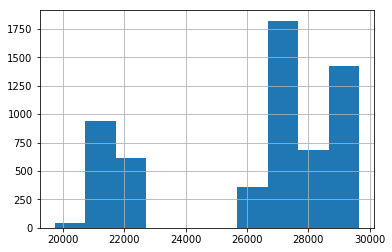

12   1.20  1.30  5859   16905.900  29700.800 


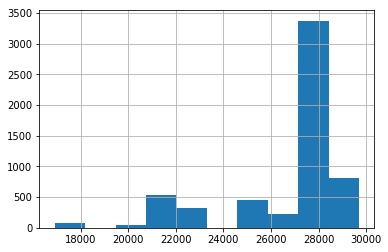

13   1.30  1.40  4330   16763.500  29979.400 


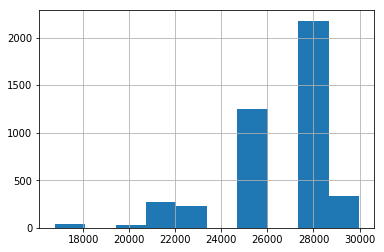

14   1.40  1.50  1341   18620.000  28478.500 


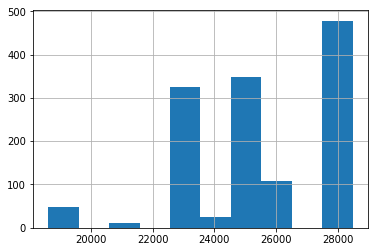

15   1.50  1.60  1763   16837.600  27812.000 


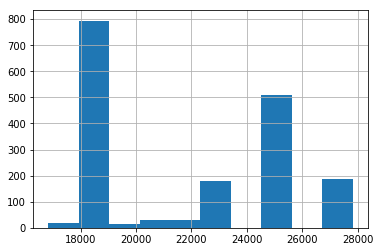

16   1.60  1.70  1594   17821.300  27942.000 


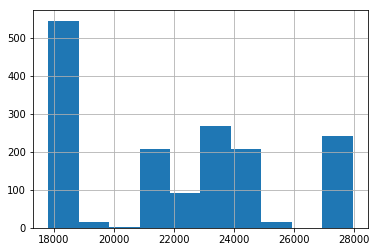

17   1.70  1.80  624    18293.100  27946.600 


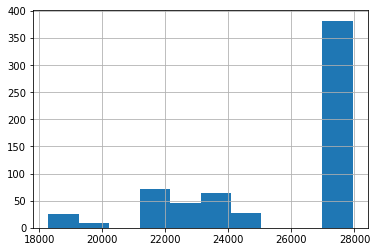

18   1.80  1.90  885    17936.100  27914.600 


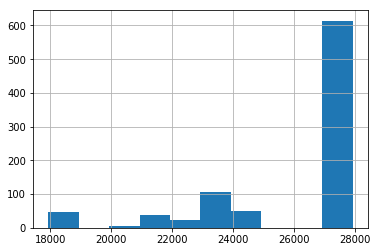

19   1.90  2.00  857    18278.900  27896.100 


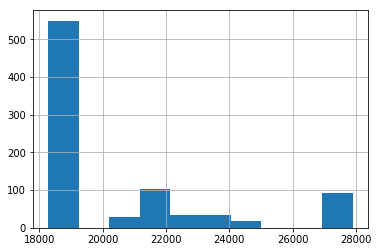

20   2.00  2.10  225    18279.500  27844.900 


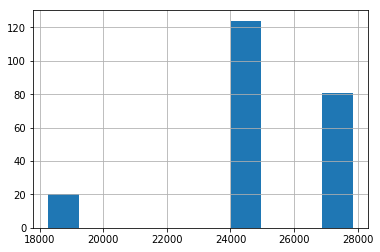

21   2.10  2.20  56     24066.100  24432.700 


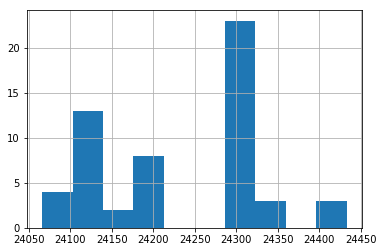

22   2.20  2.30  45     18279.500  24420.000 


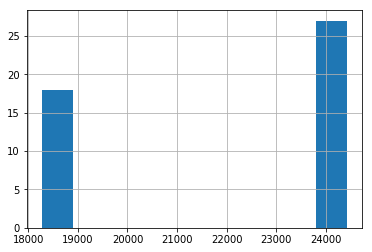

23   2.30  2.40  0      nan        nan       
24   2.40  2.50  13     19046.400  19057.900 


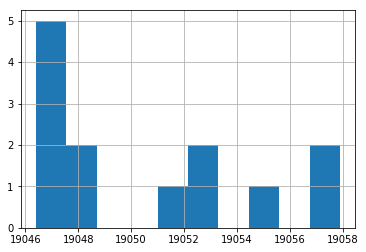

25   2.50  2.60  156    19046.400  19084.700 


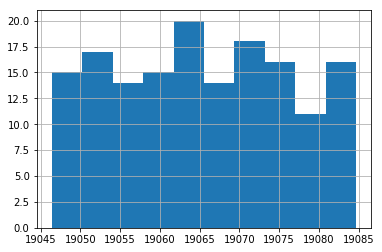

26   2.60  2.70  7      19073.100  19083.800 


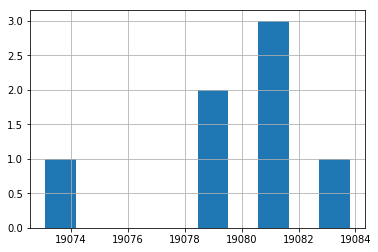

27   2.70  2.80  0      nan        nan       
28   2.80  2.90  0      nan        nan       
29   2.90  3.00  0      nan        nan       
30   3.00  3.10  0      nan        nan       
31   3.10  3.20  0      nan        nan       
32   3.20  3.30  0      nan        nan       
33   3.30  3.40  0      nan        nan       
34   3.40  3.50  0      nan        nan       
35   3.50  3.60  0      nan        nan       
36   3.60  3.70  5      26046.500  26059.700 


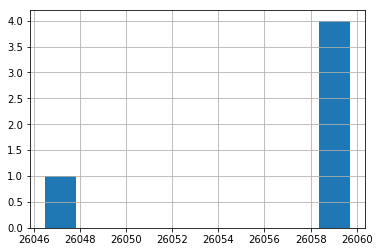

37   3.70  3.80  0      nan        nan       
38   3.80  3.90  0      nan        nan       
39   3.90  4.00  0      nan        nan       
40   4.00  4.10  0      nan        nan       


In [31]:
mean_bg_mean = []
mean_gps_alt_vals = []
median_gps_alt_vals = []
quantile_025_gps_alt_vals = []
quantile_975_gps_alt_vals = []
std_gps_alt_vals = []
count_gps_alt_vals = []

bin_width = 0.10
for i in range(0,math.ceil(4/bin_width)+1):
    min_v = i*bin_width
    max_v = min_v + bin_width
    t_filtered_df = filtered_df[(min_v <= filtered_df.bg_mean) & (filtered_df.bg_mean < max_v)]
    print("{:<4d} {:<5.2f} {:<5.2f} {:<6d} {:<10.3f} {:<10.3f}".format(
        i, min_v, max_v, len(t_filtered_df), t_filtered_df.gps_alt_mean.min(), t_filtered_df.gps_alt_mean.max()
    ))
    if len(t_filtered_df) > 0:
        t_filtered_df.gps_alt_mean.hist()
        plt.show()
        
        mean_bg_mean.append(np.mean([min_v,max_v]))
        mean_gps_alt_vals.append(t_filtered_df.gps_alt_mean.mean())
        median_gps_alt_vals.append(t_filtered_df.gps_alt_mean.median())
        quantile_025_gps_alt_vals.append(t_filtered_df.gps_alt_mean.quantile(0.025))
        quantile_975_gps_alt_vals.append(t_filtered_df.gps_alt_mean.quantile(0.975))
        std_gps_alt_vals.append(t_filtered_df.gps_alt_mean.std())
        count_gps_alt_vals.append(t_filtered_df.gps_alt_mean.count())
    
# filtered_df 

In [32]:
print('mean_bg_mean')
print(['{:.2f}'.format(v) for v in mean_bg_mean])
print('mean_gps_alt_vals')
print(['{:.2f}'.format(v) for v in mean_gps_alt_vals])
print('median_gps_alt_vals')
print(['{:.2f}'.format(v) for v in median_gps_alt_vals])
print('quantile_025_gps_alt_vals')
print(['{:.2f}'.format(v) for v in quantile_025_gps_alt_vals])
print('quantile_975_gps_alt_vals')
print(['{:.2f}'.format(v) for v in quantile_975_gps_alt_vals])
print('std_gps_alt_vals')
print(['{:.2f}'.format(v) for v in std_gps_alt_vals])
print('count_gps_alt_vals')
print(['{:.2f}'.format(v) for v in count_gps_alt_vals])

mean_bg_mean
['0.05', '0.15', '0.25', '0.35', '0.45', '0.55', '0.65', '0.95', '1.05', '1.15', '1.25', '1.35', '1.45', '1.55', '1.65', '1.75', '1.85', '1.95', '2.05', '2.15', '2.25', '2.45', '2.55', '2.65', '3.65']
mean_gps_alt_vals
['23966.60', '24962.58', '19392.74', '19084.85', '27606.43', '27764.12', '26872.95', '27697.04', '26956.34', '26406.95', '26911.28', '26767.52', '25441.73', '21766.54', '22125.85', '25659.83', '26157.30', '20223.08', '24986.33', '24235.19', '21929.90', '19050.60', '19065.31', '19079.63', '26057.06']
median_gps_alt_vals
['23984.70', '28155.70', '19909.20', '19077.50', '26474.50', '27418.20', '26871.30', '27815.85', '27051.30', '27475.10', '28251.20', '28372.50', '25288.80', '21361.10', '22476.20', '27809.30', '27859.50', '18280.50', '24270.10', '24293.50', '24336.80', '19048.30', '19065.00', '19080.90', '26059.70']
quantile_025_gps_alt_vals
['23853.75', '16736.10', '16792.87', '16813.13', '26119.83', '26763.65', '26867.70', '23877.50', '21265.50', '21221.00',

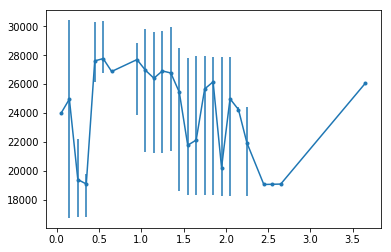

In [33]:
yerr=[np.array(mean_gps_alt_vals) - np.array(quantile_025_gps_alt_vals), 
      np.array(quantile_975_gps_alt_vals) - np.array(mean_gps_alt_vals)]
plt.errorbar(mean_bg_mean, mean_gps_alt_vals, marker='.', yerr=yerr)
plt.show()

In [34]:
# probably not correct
# inspired by https://machinelearningmastery.com/confidence-intervals-for-machine-learning/
def bootstrap_quantiles(df, p, bootstrap_size=100):
    means = np.zeros(bootstrap_size)
    for i in range(bootstrap_size):
        indices = np.random.randint(0, len(df), 500)
        means[i]=df.iloc[indices][p].mean()
    return np.percentile(means,2.5),np.percentile(means,50),np.percentile(means,97.5)

0    16000.00 16500.00 0      nan        nan       
1    16500.00 17000.00 5163   0.121      1.591     


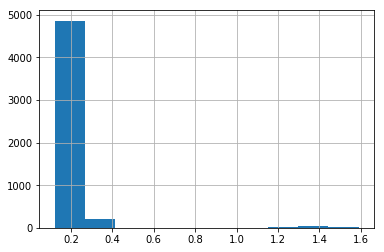

2    17000.00 17500.00 3196   0.120      0.219     


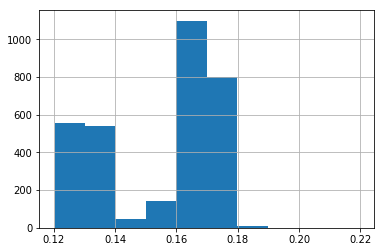

3    17500.00 18000.00 4397   0.123      1.849     


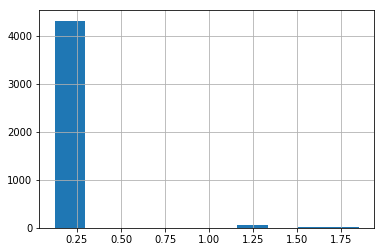

4    18000.00 18500.00 1936   1.528      2.229     


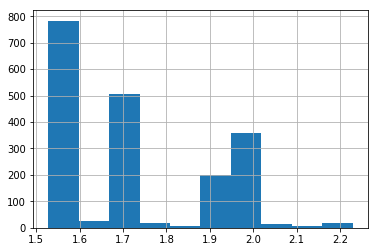

5    18500.00 19000.00 1053   0.209      1.891     


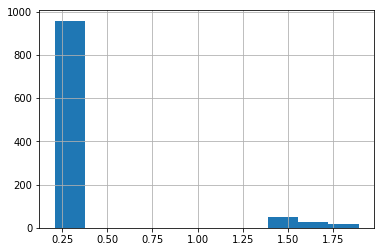

6    19000.00 19500.00 403    0.271      2.625     


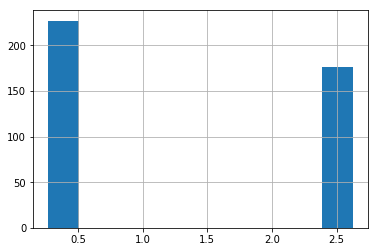

7    19500.00 20000.00 567    0.219      1.750     


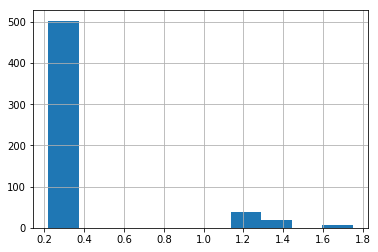

8    20000.00 20500.00 1347   0.180      1.984     


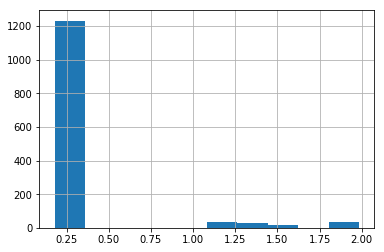

9    20500.00 21000.00 357    0.237      1.566     


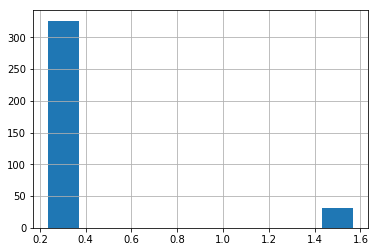

10   21000.00 21500.00 9552   0.106      1.994     


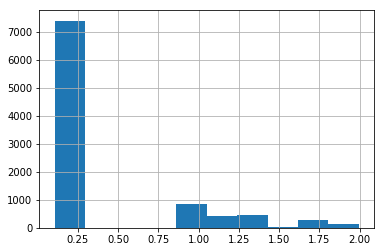

11   21500.00 22000.00 6349   0.112      1.252     


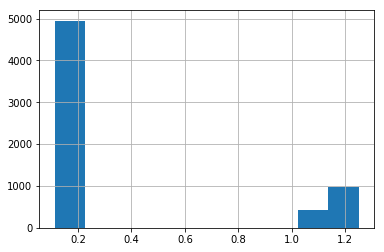

12   22000.00 22500.00 1537   0.150      1.932     


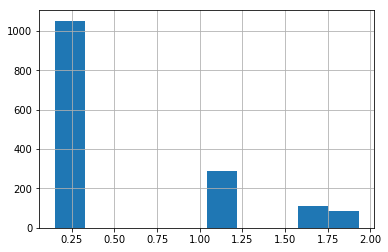

13   22500.00 23000.00 1815   0.138      13.180    


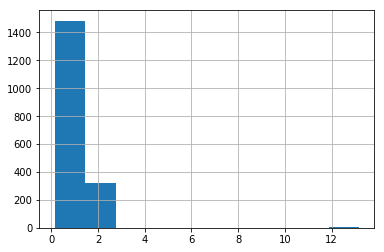

14   23000.00 23500.00 1737   0.123      1.530     


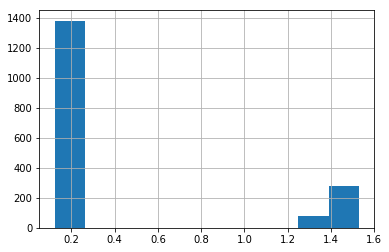

15   23500.00 24000.00 3417   0.097      1.928     


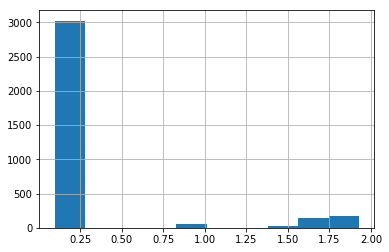

16   24000.00 24500.00 249    1.894      2.259     


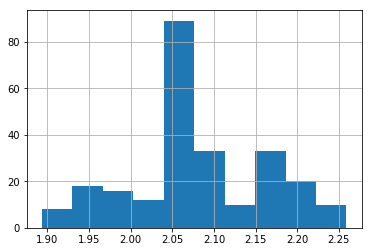

17   24500.00 25000.00 811    1.399      1.883     


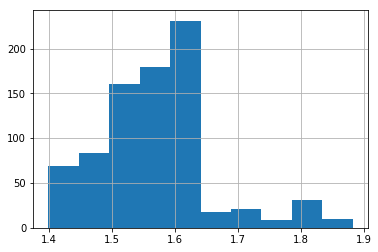

18   25000.00 25500.00 986    1.270      1.633     


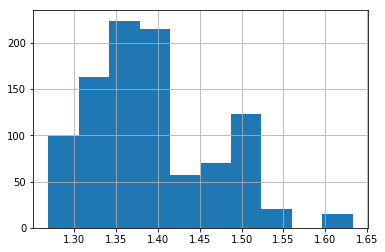

19   25500.00 26000.00 1504   1.098      1.428     


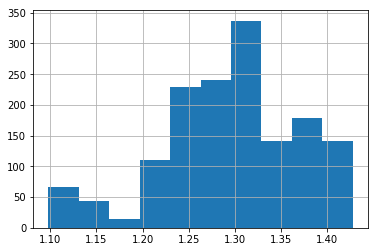

20   26000.00 26500.00 1920   0.406      3.628     


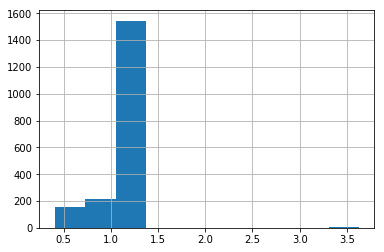

21   26500.00 27000.00 1561   0.429      1.102     


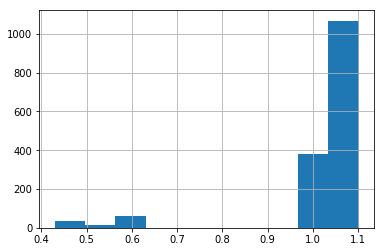

22   27000.00 27500.00 3897   0.507      1.185     


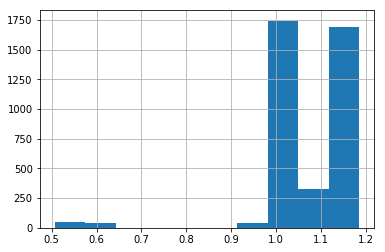

23   27500.00 28000.00 2646   0.512      2.036     


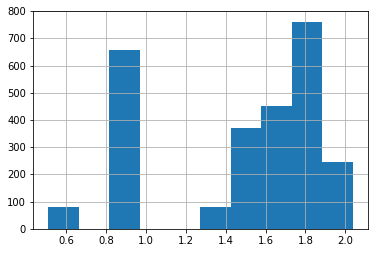

24   28000.00 28500.00 10292  0.107      1.469     


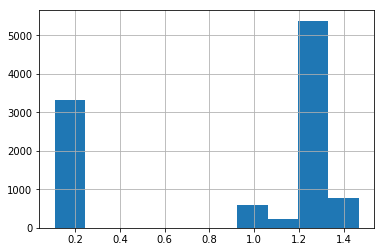

25   28500.00 29000.00 6497   0.115      1.227     


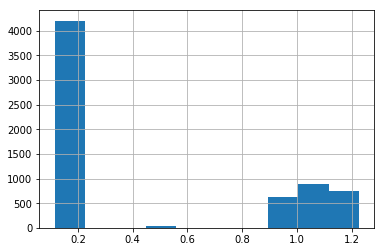

26   29000.00 29500.00 8731   0.113      1.176     


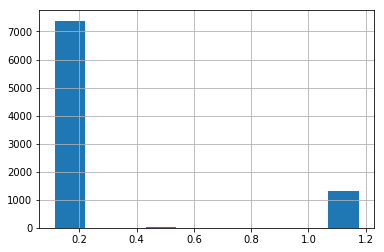

27   29500.00 30000.00 16123  0.108      1.363     


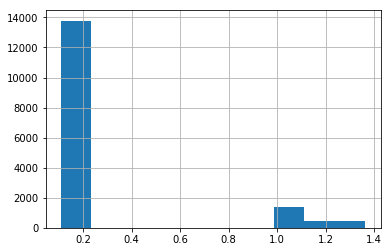

28   30000.00 30500.00 2275   0.139      0.528     


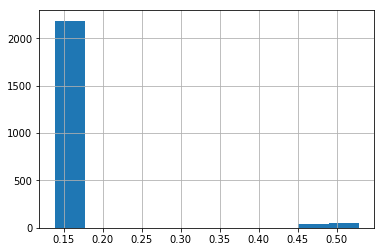

29   30500.00 31000.00 297    0.142      0.151     


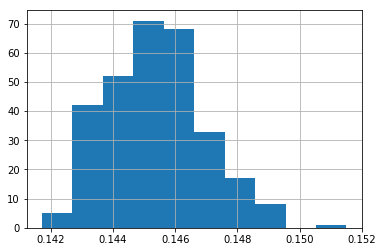

30   31000.00 31500.00 0      nan        nan       
31   31500.00 32000.00 0      nan        nan       
32   32000.00 32500.00 0      nan        nan       
33   32500.00 33000.00 0      nan        nan       
34   33000.00 33500.00 0      nan        nan       
35   33500.00 34000.00 0      nan        nan       
36   34000.00 34500.00 0      nan        nan       
37   34500.00 35000.00 0      nan        nan       
38   35000.00 35500.00 0      nan        nan       
39   35500.00 36000.00 0      nan        nan       
40   36000.00 36500.00 0      nan        nan       


In [35]:
bins_offset = 16000
bin_width = 500

mean_gps_alt = []
mean_bg_mean_vals = []
median_bg_mean_vals = []
quantile_025_bg_mean_vals = []
quantile_975_bg_mean_vals = []
std_bg_mean_vals = []
count_bg_mean_vals = []

b_median_bg_mean_vals = []
b_quantile_025_bg_mean_vals = []
b_quantile_975_bg_mean_vals = []

for i in range(0,math.ceil((36000 - bins_offset)/bin_width)+1):
    min_v = bins_offset + i*bin_width
    max_v = min_v + bin_width
    t_filtered_df = filtered_df[(min_v <= filtered_df.gps_alt_mean) & (filtered_df.gps_alt_mean < max_v)]
    print("{:<4d} {:<5.2f} {:<5.2f} {:<6d} {:<10.3f} {:<10.3f}".format(
        i, min_v, max_v, len(t_filtered_df), t_filtered_df.bg_mean.min(), t_filtered_df.bg_mean.max()
    ))
    if len(t_filtered_df) > 0:
        t_filtered_df.bg_mean.hist()
        plt.show()
        
        mean_gps_alt.append(np.mean([min_v,max_v]))
        mean_bg_mean_vals.append(t_filtered_df.bg_mean.mean())
        median_bg_mean_vals.append(t_filtered_df.bg_mean.median())
        quantile_025_bg_mean_vals.append(t_filtered_df.bg_mean.quantile(0.025))
        quantile_975_bg_mean_vals.append(t_filtered_df.bg_mean.quantile(0.975))
        std_bg_mean_vals.append(t_filtered_df.bg_mean.std())
        count_bg_mean_vals.append(t_filtered_df.bg_mean.count())
        
        b_q025, b_m, b_q975 = bootstrap_quantiles(t_filtered_df, 'bg_mean')
        b_median_bg_mean_vals.append(b_m)
        b_quantile_025_bg_mean_vals.append(b_q025)
        b_quantile_975_bg_mean_vals.append(b_q975)
        
    
# filtered_df 

In [36]:
print('mean_gps_alt')
print(['{:.2f}'.format(v) for v in mean_gps_alt])
print('mean_bg_mean_vals')
print(['{:.2f}'.format(v) for v in mean_bg_mean_vals])
print('median_bg_mean_vals')
print(['{:.2f}'.format(v) for v in median_bg_mean_vals])
print('quantile_025_bg_mean_vals')
print(['{:.2f}'.format(v) for v in quantile_025_bg_mean_vals])
print('quantile_975_bg_mean_vals')
print(['{:.2f}'.format(v) for v in quantile_975_bg_mean_vals])
print('std_bg_mean_vals')
print(['{:.2f}'.format(v) for v in std_bg_mean_vals])
print('count_bg_mean_vals')
print(['{:.2f}'.format(v) for v in count_bg_mean_vals])
print('b_median_bg_mean_vals')
print(['{:.2f}'.format(v) for v in b_median_bg_mean_vals])
print('b_quantile_025_bg_mean_vals')
print(['{:.2f}'.format(v) for v in b_quantile_025_bg_mean_vals])
print('b_quantile_975_bg_mean_vals')
print(['{:.2f}'.format(v) for v in b_quantile_975_bg_mean_vals])

mean_gps_alt
['16750.00', '17250.00', '17750.00', '18250.00', '18750.00', '19250.00', '19750.00', '20250.00', '20750.00', '21250.00', '21750.00', '22250.00', '22750.00', '23250.00', '23750.00', '24250.00', '24750.00', '25250.00', '25750.00', '26250.00', '26750.00', '27250.00', '27750.00', '28250.00', '28750.00', '29250.00', '29750.00', '30250.00', '30750.00']
mean_bg_mean_vals
['0.19', '0.15', '0.19', '1.72', '0.39', '1.28', '0.39', '0.32', '0.36', '0.40', '0.37', '0.55', '0.80', '0.41', '0.29', '2.08', '1.57', '1.39', '1.30', '1.03', '1.01', '1.06', '1.49', '0.89', '0.45', '0.27', '0.27', '0.16', '0.15']
median_bg_mean_vals
['0.16', '0.16', '0.18', '1.68', '0.28', '0.37', '0.27', '0.22', '0.25', '0.14', '0.15', '0.17', '0.20', '0.14', '0.11', '2.07', '1.58', '1.38', '1.30', '1.08', '1.05', '1.05', '1.67', '1.27', '0.13', '0.13', '0.13', '0.15', '0.15']
quantile_025_bg_mean_vals
['0.13', '0.13', '0.13', '1.53', '0.22', '0.28', '0.22', '0.18', '0.24', '0.11', '0.12', '0.15', '0.14', '0.

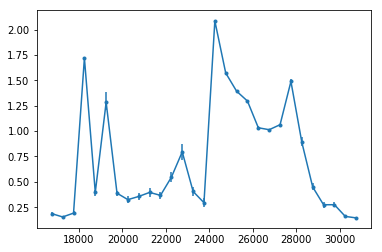

In [37]:
# probably incorrect
yerr=[np.array(b_median_bg_mean_vals) - np.array(b_quantile_025_bg_mean_vals), 
      np.array(b_quantile_975_bg_mean_vals) - np.array(b_median_bg_mean_vals)]
plt.errorbar(mean_gps_alt, b_median_bg_mean_vals, marker='.', yerr=yerr)
plt.show()

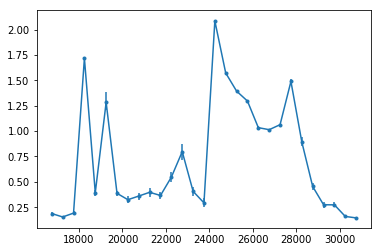

In [38]:
# probably incorrect
yerr=[np.array(mean_bg_mean_vals) - np.array(b_quantile_025_bg_mean_vals), 
      np.array(b_quantile_975_bg_mean_vals) - np.array(mean_bg_mean_vals)]
plt.errorbar(mean_gps_alt, mean_bg_mean_vals, marker='.', yerr=yerr)
plt.show()

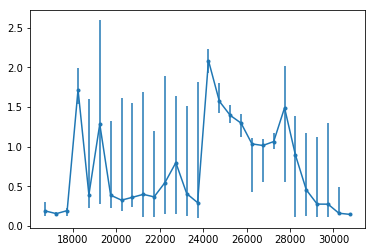

In [39]:
yerr=[np.array(mean_bg_mean_vals) - np.array(quantile_025_bg_mean_vals), 
      np.array(quantile_975_bg_mean_vals) - np.array(mean_bg_mean_vals)]
plt.errorbar(mean_gps_alt, mean_bg_mean_vals, marker='.', yerr=yerr)
plt.show()

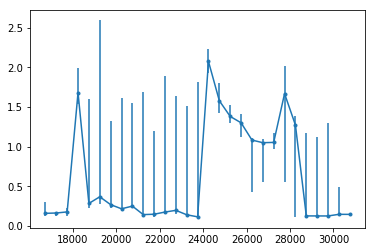

In [40]:
yerr=[np.array(median_bg_mean_vals) - np.array(quantile_025_bg_mean_vals), 
      np.array(quantile_975_bg_mean_vals) - np.array(median_bg_mean_vals)]
plt.errorbar(mean_gps_alt, median_bg_mean_vals, marker='.', yerr=yerr)
plt.show()

## Background - time relation

In [41]:
print(filtered_df.gtu_datetime_min.min())
print(filtered_df.gtu_datetime_min.min().timestamp())

2017-04-27 08:25:12.000200
1493274312.0002


In [42]:
print(len(filtered_df))

100615


0    1493274312.00 1493281512.00 0      nan        nan       
1    1493281512.00 1493288712.00 11111  0.108      1.130     


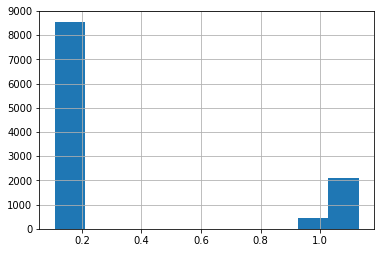

2    1493288712.00 1493295912.00 7497   0.107      1.121     


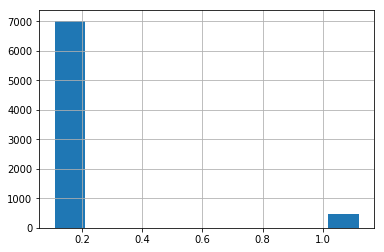

3    1493295912.00 1493303112.00 14150  0.117      1.312     


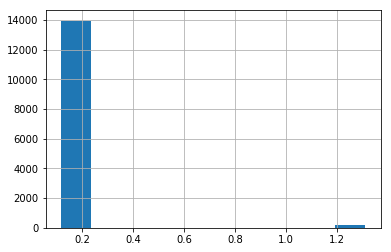

4    1493303112.00 1493310312.00 1644   0.139      0.158     


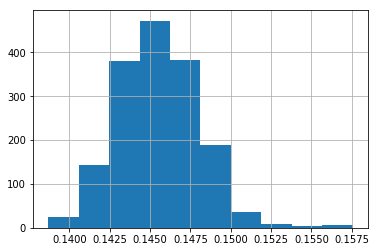

5    1493310312.00 1493317512.00 0      nan        nan       
6    1493317512.00 1493324712.00 0      nan        nan       
7    1493324712.00 1493331912.00 0      nan        nan       
8    1493331912.00 1493339112.00 0      nan        nan       
9    1493339112.00 1493346312.00 0      nan        nan       
10   1493346312.00 1493353512.00 0      nan        nan       
11   1493353512.00 1493360712.00 0      nan        nan       
12   1493360712.00 1493367912.00 84     1.145      1.169     


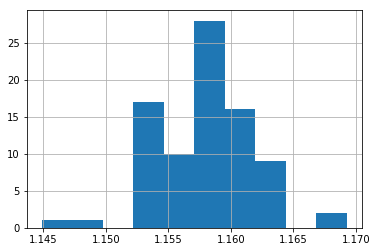

13   1493367912.00 1493375112.00 7737   0.949      1.469     


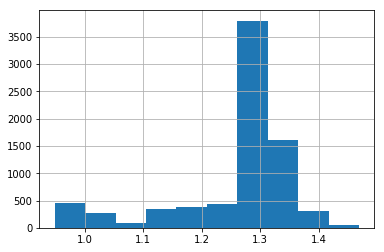

14   1493375112.00 1493382312.00 626    1.661      1.902     


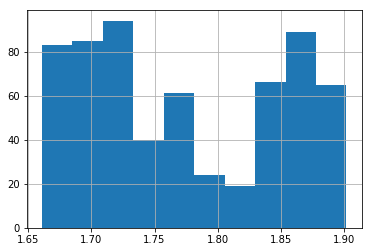

15   1493382312.00 1493389512.00 1628   1.139      2.036     


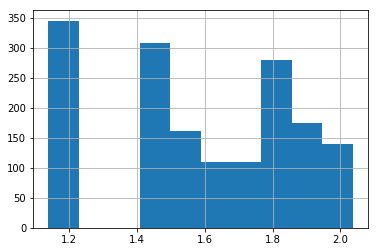

16   1493389512.00 1493396712.00 1476   1.104      1.185     


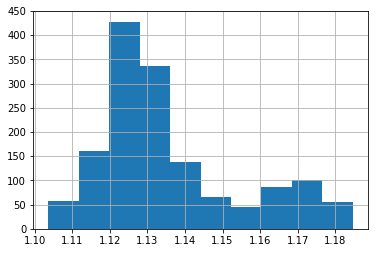

17   1493396712.00 1493403912.00 0      nan        nan       
18   1493403912.00 1493411112.00 0      nan        nan       
19   1493411112.00 1493418312.00 0      nan        nan       
20   1493418312.00 1493425512.00 0      nan        nan       
21   1493425512.00 1493432712.00 0      nan        nan       
22   1493432712.00 1493439912.00 0      nan        nan       
23   1493439912.00 1493447112.00 419    1.194      1.363     


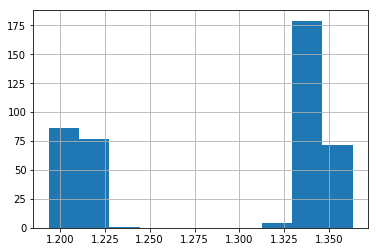

24   1493447112.00 1493454312.00 5579   0.901      1.207     


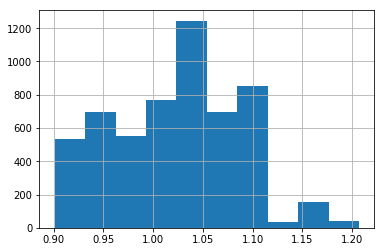

25   1493454312.00 1493461512.00 7079   0.123      2.259     


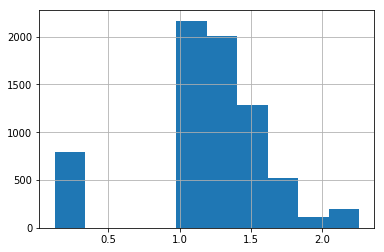

26   1493461512.00 1493468712.00 6372   0.106      1.994     


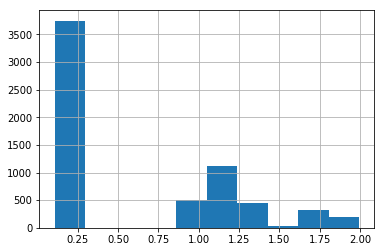

27   1493468712.00 1493475912.00 7177   0.106      1.226     


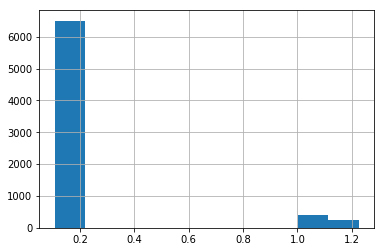

28   1493475912.00 1493483112.00 2182   0.134      1.565     


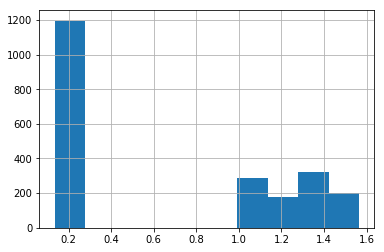

29   1493483112.00 1493490312.00 158    1.614      13.180    


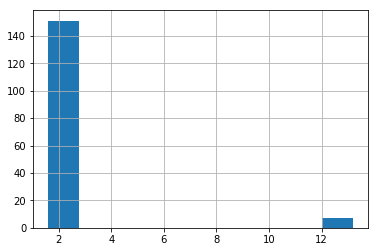

30   1493490312.00 1493497512.00 0      nan        nan       
31   1493497512.00 1493504712.00 0      nan        nan       
32   1493504712.00 1493511912.00 0      nan        nan       
33   1493511912.00 1493519112.00 0      nan        nan       
34   1493519112.00 1493526312.00 0      nan        nan       
35   1493526312.00 1493533512.00 0      nan        nan       
36   1493533512.00 1493540712.00 1422   0.173      2.625     


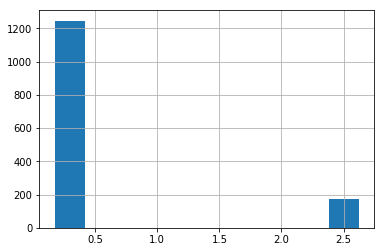

37   1493540712.00 1493547912.00 2757   0.121      1.591     


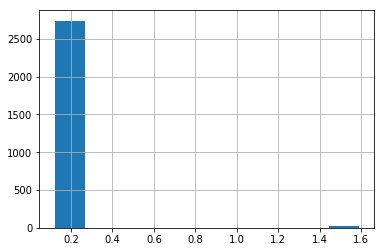

38   1493547912.00 1493555112.00 2303   0.121      1.390     


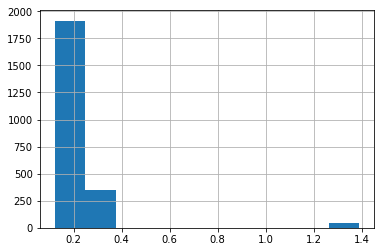

39   1493555112.00 1493562312.00 2703   0.122      1.225     


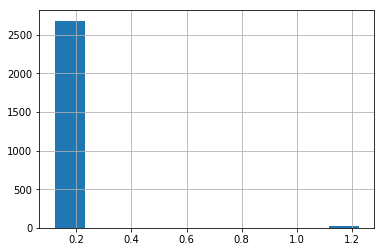

40   1493562312.00 1493569512.00 3546   0.120      1.849     


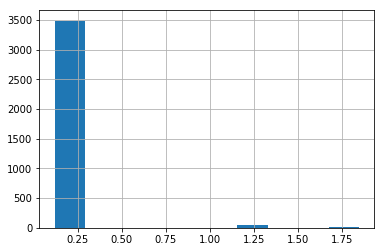

41   1493569512.00 1493576712.00 169    0.199      0.212     


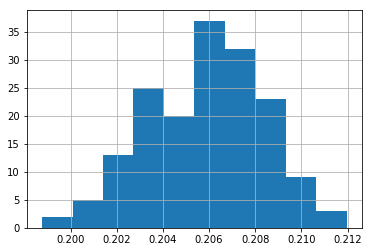

42   1493576712.00 1493583912.00 0      nan        nan       
43   1493583912.00 1493591112.00 0      nan        nan       
44   1493591112.00 1493598312.00 0      nan        nan       
45   1493598312.00 1493605512.00 0      nan        nan       
46   1493605512.00 1493612712.00 0      nan        nan       
47   1493612712.00 1493619912.00 164    0.474      0.554     


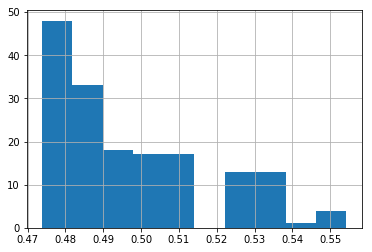

48   1493619912.00 1493627112.00 424    0.406      3.628     


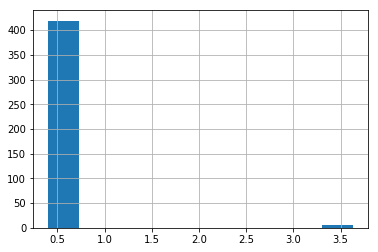

49   1493627112.00 1493634312.00 34     0.409      1.419     


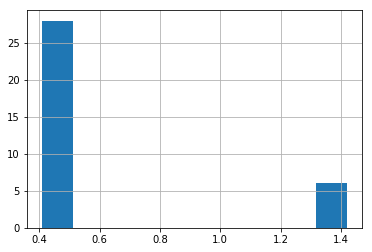

50   1493634312.00 1493641512.00 39     1.404      1.633     


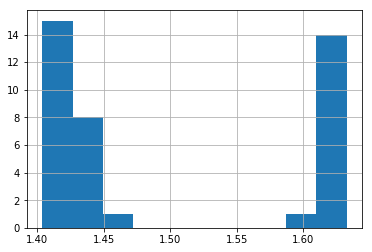

51   1493641512.00 1493648712.00 31     1.513      1.566     


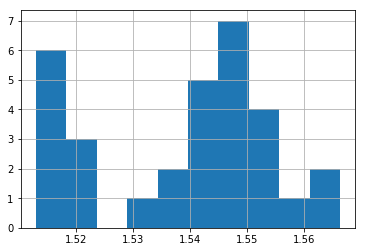

52   1493648712.00 1493655912.00 0      nan        nan       
53   1493655912.00 1493663112.00 0      nan        nan       
54   1493663112.00 1493670312.00 0      nan        nan       
55   1493670312.00 1493677512.00 0      nan        nan       
56   1493677512.00 1493684712.00 0      nan        nan       
57   1493684712.00 1493691912.00 0      nan        nan       
58   1493691912.00 1493699112.00 0      nan        nan       
59   1493699112.00 1493706312.00 0      nan        nan       
60   1493706312.00 1493713512.00 0      nan        nan       
61   1493713512.00 1493720712.00 1597   0.097      0.932     


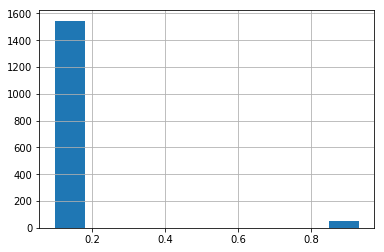

62   1493720712.00 1493727912.00 4773   0.109      1.278     


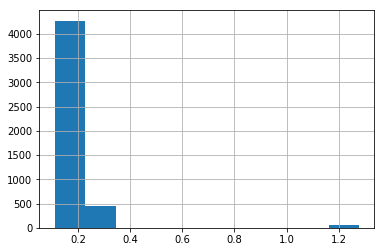

63   1493727912.00 1493735112.00 2730   0.170      1.984     


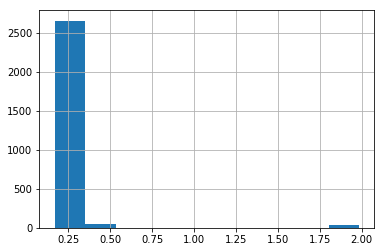

64   1493735112.00 1493742312.00 814    0.209      1.891     


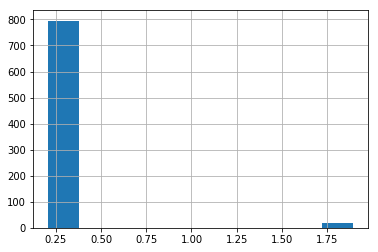

65   1493742312.00 1493749512.00 0      nan        nan       
66   1493749512.00 1493756712.00 0      nan        nan       
67   1493756712.00 1493763912.00 0      nan        nan       
68   1493763912.00 1493771112.00 0      nan        nan       
69   1493771112.00 1493778312.00 0      nan        nan       
70   1493778312.00 1493785512.00 0      nan        nan       
71   1493785512.00 1493792712.00 0      nan        nan       
72   1493792712.00 1493799912.00 0      nan        nan       
73   1493799912.00 1493807112.00 1936   1.528      2.229     


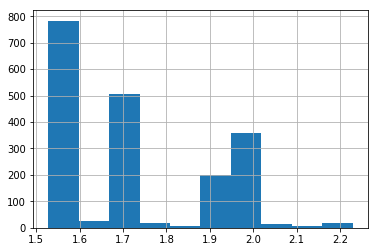

74   1493807112.00 1493814312.00 48     1.426      1.446     


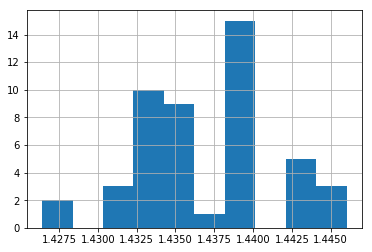

75   1493814312.00 1493821512.00 28     1.586      1.608     


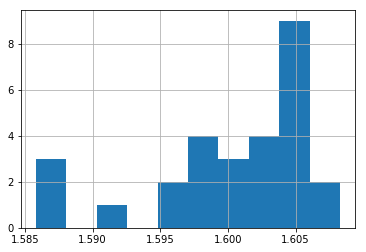

76   1493821512.00 1493828712.00 0      nan        nan       
77   1493828712.00 1493835912.00 0      nan        nan       
78   1493835912.00 1493843112.00 0      nan        nan       
79   1493843112.00 1493850312.00 0      nan        nan       
80   1493850312.00 1493857512.00 0      nan        nan       
81   1493857512.00 1493864712.00 0      nan        nan       
82   1493864712.00 1493871912.00 0      nan        nan       
83   1493871912.00 1493879112.00 0      nan        nan       
84   1493879112.00 1493886312.00 0      nan        nan       
85   1493886312.00 1493893512.00 0      nan        nan       
86   1493893512.00 1493900712.00 18     1.575      1.609     


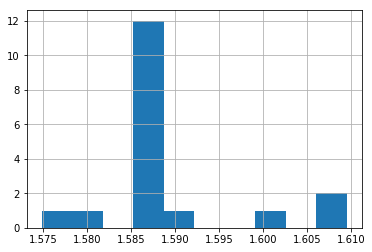

87   1493900712.00 1493907912.00 46     1.162      1.750     


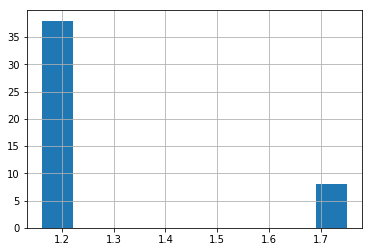

88   1493907912.00 1493915112.00 0      nan        nan       
89   1493915112.00 1493922312.00 0      nan        nan       
90   1493922312.00 1493929512.00 0      nan        nan       
91   1493929512.00 1493936712.00 0      nan        nan       
92   1493936712.00 1493943912.00 0      nan        nan       
93   1493943912.00 1493951112.00 0      nan        nan       
94   1493951112.00 1493958312.00 0      nan        nan       
95   1493958312.00 1493965512.00 0      nan        nan       
96   1493965512.00 1493972712.00 0      nan        nan       
97   1493972712.00 1493979912.00 52     1.205      1.287     


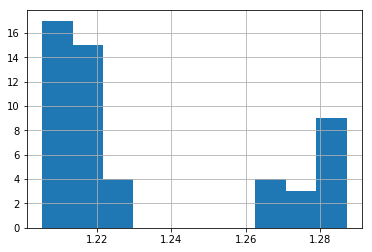

98   1493979912.00 1493987112.00 30     1.316      1.358     


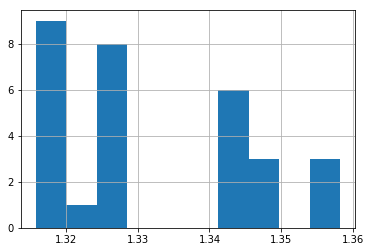

99   1493987112.00 1493994312.00 0      nan        nan       
100  1493994312.00 1494001512.00 0      nan        nan       
101  1494001512.00 1494008712.00 0      nan        nan       
102  1494008712.00 1494015912.00 0      nan        nan       
103  1494015912.00 1494023112.00 0      nan        nan       
104  1494023112.00 1494030312.00 0      nan        nan       
105  1494030312.00 1494037512.00 0      nan        nan       
106  1494037512.00 1494044712.00 0      nan        nan       
107  1494044712.00 1494051912.00 0      nan        nan       
108  1494051912.00 1494059112.00 0      nan        nan       
109  1494059112.00 1494066312.00 0      nan        nan       
110  1494066312.00 1494073512.00 32     1.239      1.648     


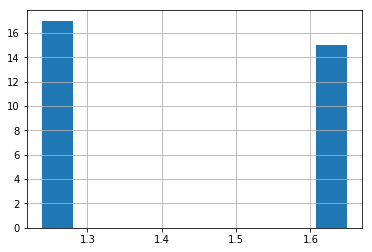

In [43]:
bins_offset = filtered_df.gtu_datetime_min.min().timestamp()
bins_range_end = filtered_df.gtu_datetime_min.max().timestamp()
bin_width = 3600*2

mean_gtu_datetime_vals = []
mean_bg_mean_vals = []
median_bg_mean_vals = []
quantile_025_bg_mean_vals = []
quantile_975_bg_mean_vals = []
std_bg_mean_vals = []
count_bg_mean_vals = []


for i in range(0,math.ceil((bins_range_end - bins_offset)/bin_width)+1):
    min_v = bins_offset + i*bin_width
    max_v = min_v + bin_width
    t_filtered_df = filtered_df[
        (datetime.datetime.utcfromtimestamp(min_v) <= filtered_df.gtu_datetime_min) \
        & (filtered_df.gtu_datetime_min < datetime.datetime.utcfromtimestamp(max_v))]
    print("{:<4d} {:<5.2f} {:<5.2f} {:<6d} {:<10.3f} {:<10.3f}".format(
        i, min_v, max_v, len(t_filtered_df), t_filtered_df.bg_mean.min(), t_filtered_df.bg_mean.max()
    ))
    if len(t_filtered_df) > 0:
        t_filtered_df.bg_mean.hist()
        plt.show()
        
        mean_gtu_datetime_vals.append(datetime.datetime.utcfromtimestamp(np.mean([min_v,max_v])))
        mean_bg_mean_vals.append(t_filtered_df.bg_mean.mean())
        median_bg_mean_vals.append(t_filtered_df.bg_mean.median())
        quantile_025_bg_mean_vals.append(t_filtered_df.bg_mean.quantile(0.025))
        quantile_975_bg_mean_vals.append(t_filtered_df.bg_mean.quantile(0.975))
        std_bg_mean_vals.append(t_filtered_df.bg_mean.std())
        count_bg_mean_vals.append(t_filtered_df.bg_mean.count())
                
    
# filtered_df 

In [44]:
print('mean_gtu_datetime_vals')
print([v.isoformat() for v in mean_gtu_datetime_vals])
print('mean_bg_mean_vals')
print(['{:.2f}'.format(v) for v in mean_bg_mean_vals])
print('median_bg_mean_vals')
print(['{:.2f}'.format(v) for v in median_bg_mean_vals])
print('quantile_025_bg_mean_vals')
print(['{:.2f}'.format(v) for v in quantile_025_bg_mean_vals])
print('quantile_975_bg_mean_vals')
print(['{:.2f}'.format(v) for v in quantile_975_bg_mean_vals])
print('std_bg_mean_vals')
print(['{:.2f}'.format(v) for v in std_bg_mean_vals])
print('count_bg_mean_vals')
print(['{:.2f}'.format(v) for v in count_bg_mean_vals])

mean_gtu_datetime_vals
['2017-04-27T09:25:12.000200', '2017-04-27T11:25:12.000200', '2017-04-27T13:25:12.000200', '2017-04-27T15:25:12.000200', '2017-04-28T07:25:12.000200', '2017-04-28T09:25:12.000200', '2017-04-28T11:25:12.000200', '2017-04-28T13:25:12.000200', '2017-04-28T15:25:12.000200', '2017-04-29T05:25:12.000200', '2017-04-29T07:25:12.000200', '2017-04-29T09:25:12.000200', '2017-04-29T11:25:12.000200', '2017-04-29T13:25:12.000200', '2017-04-29T15:25:12.000200', '2017-04-29T17:25:12.000200', '2017-04-30T07:25:12.000200', '2017-04-30T09:25:12.000200', '2017-04-30T11:25:12.000200', '2017-04-30T13:25:12.000200', '2017-04-30T15:25:12.000200', '2017-04-30T17:25:12.000200', '2017-05-01T05:25:12.000200', '2017-05-01T07:25:12.000200', '2017-05-01T09:25:12.000200', '2017-05-01T11:25:12.000200', '2017-05-01T13:25:12.000200', '2017-05-02T09:25:12.000200', '2017-05-02T11:25:12.000200', '2017-05-02T13:25:12.000200', '2017-05-02T15:25:12.000200', '2017-05-03T09:25:12.000200', '2017-05-03T11:2

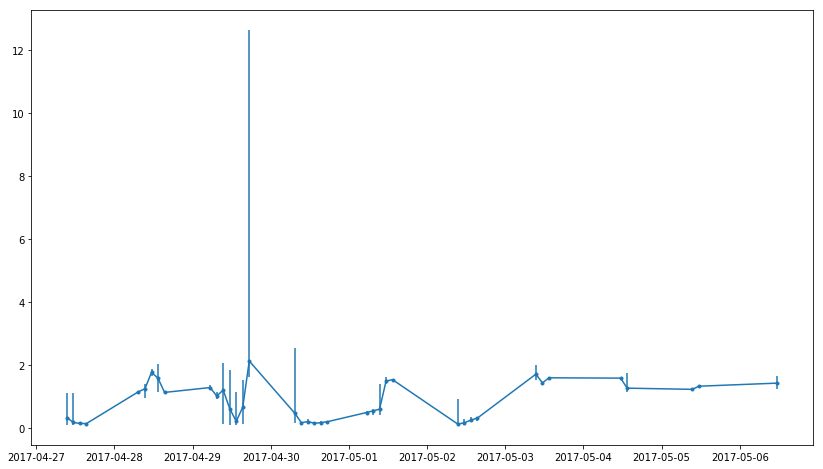

In [45]:
yerr=[np.array(mean_bg_mean_vals) - np.array(quantile_025_bg_mean_vals), 
      np.array(quantile_975_bg_mean_vals) - np.array(mean_bg_mean_vals)]
plt.figure(figsize=(14,8))
plt.errorbar(mean_gtu_datetime_vals, mean_bg_mean_vals, marker='.', yerr=yerr)
plt.show()

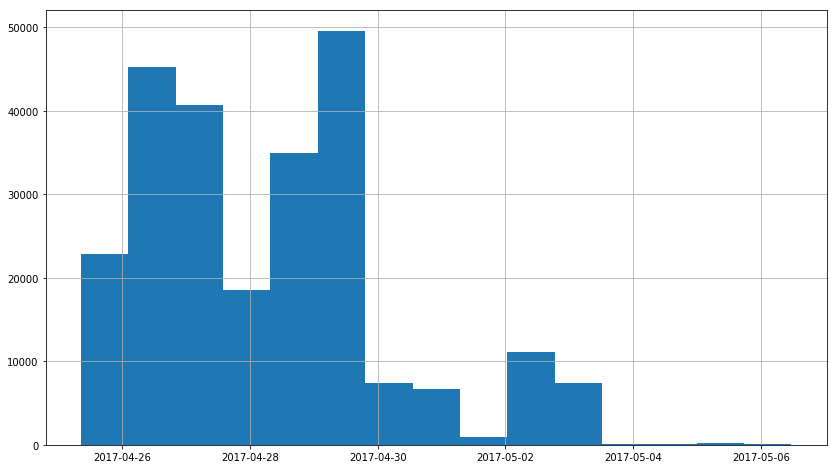

In [46]:
flight_data_df.gtu_datetime_min.hist(bins=15,figsize=(14,8))
plt.show()

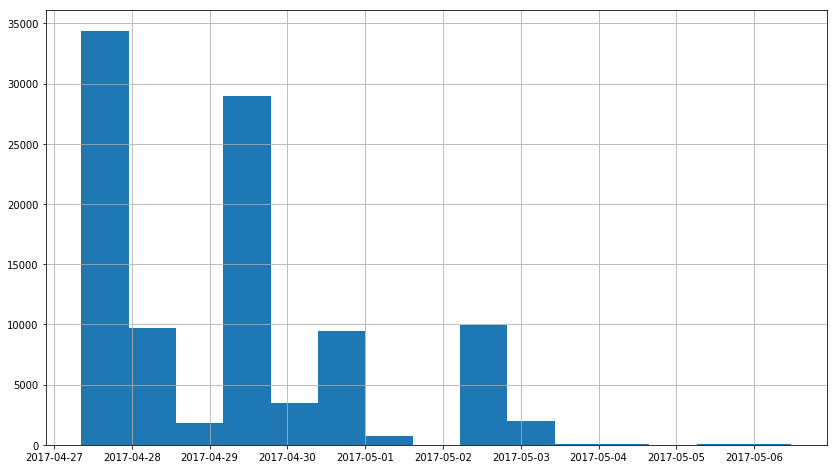

In [47]:
filtered_df.gtu_datetime_min.hist(bins=15,figsize=(14,8))
plt.show()

# Saving table of files and packets

In [49]:
table_for_bg_file_path = os.path.join(data_snippets_dir,'ver3_flatmap__bg_size_36__7_ec.tsv')
print(table_for_bg_file_path)
num_uniq = 0
if len(filtered_df) > 0:
    with open(table_for_bg_file_path, 'w') as table_for_bg_file:
        t_filtered_df_grouped = filtered_df.groupby('source_file_acquisition_full')
        for sfa, sfa_df in t_filtered_df_grouped:
            for r in sfa_df.packet_id.unique():
                num_uniq += 1
                print("{}\t{}".format(sfa, r), file=table_for_bg_file)
print("num_uniq =",num_uniq)

ver3_flatmap_data_snippets/ver3_flatmap__bg_size_36__7_ec.tsv
num_uniq = 77471


In [58]:
bins_offset = 0
bins_range = 4

for bin_width in [0.1, 0.2, 0.5, 1.0]:

    table_for_bg_dir_path = os.path.join(data_snippets_dir,'bg_mean__{}_bins'.format(
        '{:.2f}'.format(bin_width).replace('.','_')
    ))
    os.makedirs(table_for_bg_dir_path, exist_ok=True)
    
    table_for_bg_file_path_format = os.path.join(table_for_bg_dir_path,'ver3_flatmap__bg_size_36__7_ec__bg_mean_{}.tsv')
    
    for i in range(0,math.ceil(bins_range/bin_width)+1):
        min_v = bins_offset + i*bin_width
        max_v = min_v + bin_width
        t_filtered_df = filtered_df[(min_v <= filtered_df.bg_mean) & (filtered_df.bg_mean < max_v)]
        print("{:<4d} {:<5.2f} {:<5.2f} {:<6d} {:<10.3f} {:<10.3f}".format(
            i, min_v, max_v, len(t_filtered_df), t_filtered_df.gps_alt_mean.min(), t_filtered_df.gps_alt_mean.max()
        ))
        if len(t_filtered_df) > 0:
            t_filtered_df_grouped = t_filtered_df.groupby('source_file_acquisition_full')
            
            table_for_bg_file_path = table_for_bg_file_path_format.format(
                '{:.2f}'.format(np.mean([min_v,max_v])).replace('.','_'))
            print(table_for_bg_file_path)
            
            num_uniq = 0
            with open(table_for_bg_file_path, 'w') as table_for_bg_file:
                for sfa, sfa_df in t_filtered_df_grouped:
                    for r in sfa_df.packet_id.unique():
                        num_uniq += 1
                        print("{}\t{}".format(sfa, r), file=table_for_bg_file)
            print(num_uniq)
            
    print('-'*30)

0    0.00  0.10  46     23852.800  23992.100 
ver3_flatmap_data_snippets/bg_mean__0_10_bins/ver3_flatmap__bg_size_36__7_ec__bg_mean_0_05.tsv
46
1    0.10  0.20  60362  16601.400  30516.400 
ver3_flatmap_data_snippets/bg_mean__0_10_bins/ver3_flatmap__bg_size_36__7_ec__bg_mean_0_15.tsv
50830
2    0.20  0.30  4895   16687.300  22692.900 
ver3_flatmap_data_snippets/bg_mean__0_10_bins/ver3_flatmap__bg_size_36__7_ec__bg_mean_0_25.tsv
4542
3    0.30  0.40  448    16796.300  19797.800 
ver3_flatmap_data_snippets/bg_mean__0_10_bins/ver3_flatmap__bg_size_36__7_ec__bg_mean_0_35.tsv
432
4    0.40  0.50  298    26079.100  30322.800 
ver3_flatmap_data_snippets/bg_mean__0_10_bins/ver3_flatmap__bg_size_36__7_ec__bg_mean_0_45.tsv
287
5    0.50  0.60  298    26697.700  30479.100 
ver3_flatmap_data_snippets/bg_mean__0_10_bins/ver3_flatmap__bg_size_36__7_ec__bg_mean_0_55.tsv
298
6    0.60  0.70  15     26867.700  26880.400 
ver3_flatmap_data_snippets/bg_mean__0_10_bins/ver3_flatmap__bg_size_36__7_ec__bg_m

27515
2    2.00  3.00  502    18279.500  27844.900 
ver3_flatmap_data_snippets/bg_mean__1_00_bins/ver3_flatmap__bg_size_36__7_ec__bg_mean_2_50.tsv
476
3    3.00  4.00  5      26046.500  26059.700 
ver3_flatmap_data_snippets/bg_mean__1_00_bins/ver3_flatmap__bg_size_36__7_ec__bg_mean_3_50.tsv
5
4    4.00  5.00  0      nan        nan       
------------------------------


In [ ]:
flight_data_df[(flight_data_df.bg_size >= 36) & (flight_data_df.bg_size >= 36) & (flight_data_df.gtu_in_packet >= 40)]

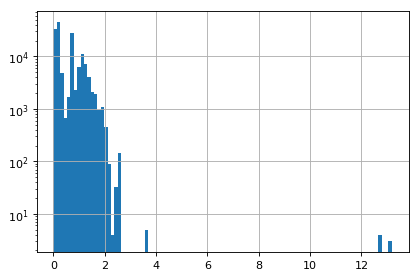

0.239788
0.5429243145223521


In [52]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[flight_data_df.bg_size >= 36]
h = filtered_df.bg_mean.hist(bins=100)
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))

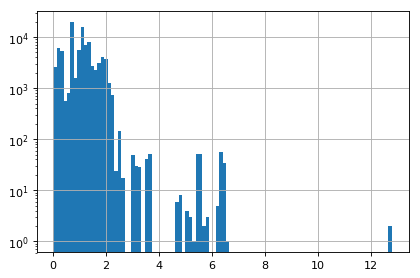

1.07894
1.0572456848939635


In [54]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[flight_data_df.bg_size < 36]
h = filtered_df.bg_mean.hist(bins=100)
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))

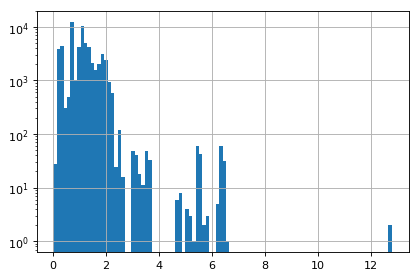

1.09304
1.110752034098872


In [55]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[flight_data_df.bg_size < 20]
h = filtered_df.bg_mean.hist(bins=100)
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))

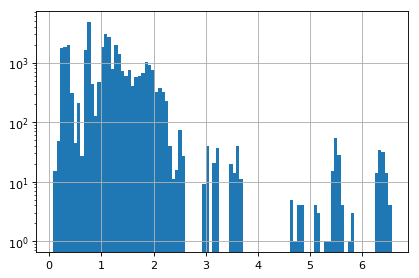

1.09141
1.1213804249357853


In [56]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[flight_data_df.bg_size < 10]
h = filtered_df.bg_mean.hist(bins=100)
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))

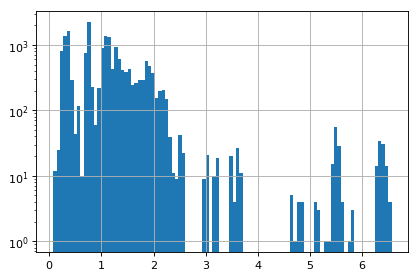

1.07711
1.1208636148342919


In [57]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[flight_data_df.bg_size < 5]
h = filtered_df.bg_mean.hist(bins=100)
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))

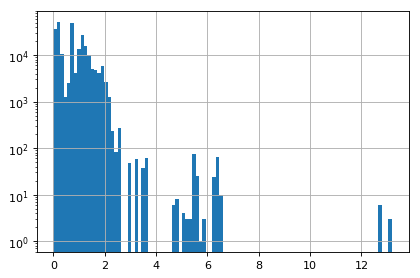

In [44]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_mean.hist(bins=100)
h.set_yscale('log')
plt.show()

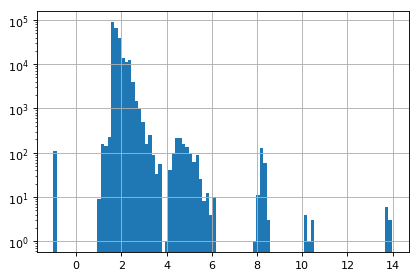

In [37]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_mean_gz.hist(bins=100)
h.set_yscale('log')
plt.show()

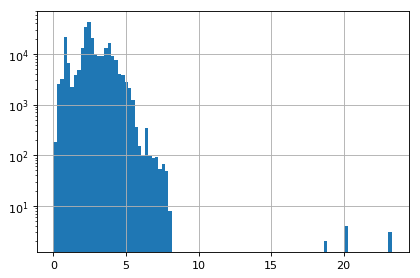

In [34]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_x_y_mean.hist(bins=100)
h.set_yscale('log')
plt.show()

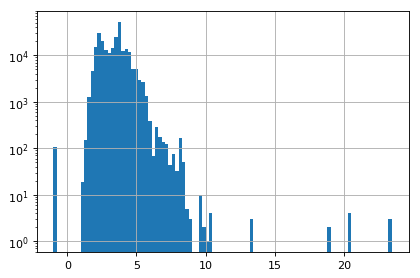

In [35]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_x_y_mean_gz.hist(bins=100)
h.set_yscale('log')
plt.show()

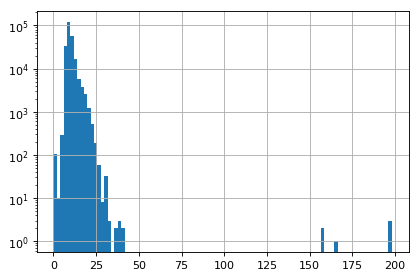

In [33]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_x_y_max.hist(bins=100)
h.set_yscale('log')
plt.show()

In [77]:
import seaborn

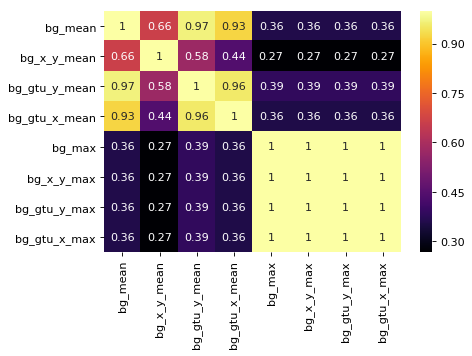

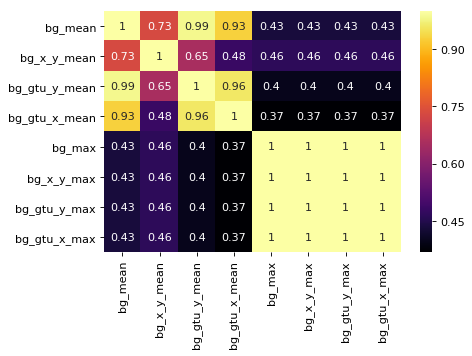

In [80]:
flight_data_corr_df = flight_data_df[['bg_mean','bg_x_y_mean','bg_gtu_y_mean','bg_gtu_x_mean',
                                      'bg_max','bg_x_y_max','bg_gtu_y_max','bg_gtu_x_max']].corr()
f, ax = plt.subplots(figsize=(28,22))

#Draw the heatmap using seaborn
plt.close('all')
seaborn.heatmap(flight_data_corr_df, cmap='inferno', annot=True)
plt.show()

filtered_df = flight_data_df[(flight_data_df.bg_size >= 36) & (flight_data_df.gtu_in_packet >= 40)]
flight_data_corr_df = filtered_df[['bg_mean','bg_x_y_mean','bg_gtu_y_mean','bg_gtu_x_mean',
                                      'bg_max','bg_x_y_max','bg_gtu_y_max','bg_gtu_x_max']].corr()
f, ax = plt.subplots(figsize=(28,22))

#Draw the heatmap using seaborn
plt.close('all')
seaborn.heatmap(flight_data_corr_df, cmap='inferno', annot=True)
plt.show()

In [48]:
# current_columns_for_analysis_dict = split_columns_for_analysis_dict[0]

# select_clause_str, joined_tables_list = \
#     query_functions.get_query_clauses__select(current_columns_for_analysis_dict)
# join_clauses_str = \
#     query_functions.get_query_clauses__join(joined_tables_list)
# where_clauses_str = ' AND config_info_id=2'
    
# events_selection_query = query_functions.get_events_selection_query_plain(
#     source_data_type_num=1,
#     select_additional=select_clause_str, join_additional=join_clauses_str,
#     where_additional=where_clauses_str,
#     order_by='{data_table_name}.event_id', limit=350000, offset=0,
#     base_select='',
#     data_table_name_overwrite=events_data_table_name)

# flight_data_2_df = psql.read_sql(events_selection_query, event_v3_storage_provider.connection)

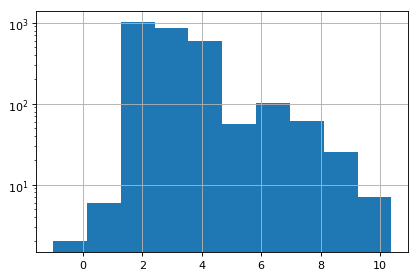

In [49]:
# plt.close('all')
# # fig, ax = plt.subplots(1,1)
# h = flight_data_2_df.bg_x_y_mean_gz.hist()
# h.set_yscale('log')
# plt.show()